# 📑 LLM - Detect AI Generated Text - with RoBERTa

This project aims to develop robust and accurate methods for detecting AI-generated text, utilizing advanced natural language processing (NLP) and machine learning techniques. By delving into the nuances of language patterns, syntactic structures, and semantic cues, our goal is to create a tool that can reliably identify instances where text originates from AI models.

For this project we will use a dataset that cantains around 10,000 essays written by humans and by AI generated text. 

The dataset set was taken from Kaggle, it is a collection of many essays prepared for a Kaggle competition, here is the [link.](https://www.kaggle.com/datasets/thedrcat/daigt-proper-train-dataset/data?select=train_drcat_04.csv)




## Importing Libraries

In [42]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay, confusion_matrix
import matplotlib.pyplot as plt

## Load and Preparing the dataset

In [3]:
main_dataframe = pd.read_csv('/train_drcat_04.csv')

### Exploratory Data Analysis

Let's check our dataset. 

In [4]:
main_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44206 entries, 0 to 44205
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   essay_id  44206 non-null  object
 1   text      44206 non-null  object
 2   label     44206 non-null  int64 
 3   source    44206 non-null  object
 4   prompt    12911 non-null  object
 5   fold      44206 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [5]:
main_dataframe.head()

,essay_id,text,label,source,prompt,fold
0,E897534557AF,"In recent years, technology has had a profoun...",1,mistral7binstruct_v2,\nTask: Write an essay discussing the positive...,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,0,persuade_corpus,NaN,2
2,af37ecf5,The electoral college is a symbol of mockery a...,0,train_essays,NaN,5
3,5EC2696BAD78,This is why I think the principle should allow...,0,persuade_corpus,NaN,8
4,llama_70b_v1843,I strongly believe that meditation and mindful...,1,llama_70b_v1,Some schools have implemented meditation and m...,0


Basically we only need the `text` and `label`, the other columns are information added to identify the source of the data, we cannot train our model with the prompt columns because will be a clearly indicator that it is AI Generated text, also the test data doesn't provide the prompts due to we should be able to idenfity if the text provided is AI Generated or not, only with the text itself. 

In [8]:
# Let'scheck the labels
main_dataframe['label'].value_counts()

label
0    29792
1    14414
Name: count, dtype: int64

### Split the data

Due to our data is not balanced, we will take a sample of aprox. 10,000 essays trying to balance the data 50% on each category.

In [9]:
# Let's remove any duplicate essay in our dataframe.
main_dataframe.drop_duplicates(subset='text', inplace=True)

# Let's use the folds in our dataframe to split the data and.
fold_0 = main_dataframe[(main_dataframe['fold'] == 4)]
fold_1 = main_dataframe[(main_dataframe['fold'] == 8)]
fold_2 = main_dataframe[(main_dataframe['fold'] == 6)]
fold_3 = main_dataframe[(main_dataframe['fold'] == 3)]
fold_0 = fold_0.drop(fold_0[fold_0.label == 0].index)
fold_3 = fold_3.drop(fold_3[fold_3.label == 0].index)

folds = [fold_0, fold_1, fold_2, fold_3]

df_with_folds = pd.concat(folds)

# We are going to use the text in the fold #7 to make sure it is completly different from our train data.
X_val = main_dataframe[main_dataframe['fold'] == 7]
y_val = main_dataframe[main_dataframe['fold'] == 7]

In [11]:
# Let's check if the data is balanced
df_with_folds['label'].value_counts()

label
0    5951
1    5765
Name: count, dtype: int64

In [12]:
# Splitting the data into train and validation set
X_train = df_with_folds['text'].tolist()
X_val = X_val['text'].tolist()
y_train = df_with_folds['label'].tolist()
y_val = y_val['label'].tolist()

## Tokenization

In [13]:
# Function to tokenize 
def tokenize(tokenizer, texts, max_length=512, return_tensors='pt'):
    tokenized_texts = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors=return_tensors
    )
    return tokenized_texts

# Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the texts
X_train_encodings = tokenize(tokenizer, X_train)
X_val_encodings = tokenize(tokenizer, X_val)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

### Creating a Dataset

In [14]:
# Create PyTorch datasets
class CustomDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        # If labels are None, return the length of the encodings
        if self.labels is not None:
            return len(self.labels)
        else:
            # If labels are None, return the length of any key in encodings
            return len(next(iter(self.encodings.values())))

train_dataset = CustomDataset(X_train_encodings, y_train)
val_dataset = CustomDataset(X_val_encodings, y_val) 

## Model training

In [15]:
# Load pre-trained RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
model = model.to('cuda')  # Move the model to GPU

# Define training parameters
optimizer = torch.optim.NAdam(model.parameters(), lr=2e-5, weight_decay=1e-5)  # lr 5e-5, wd 5e-5
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=16, shuffle=False) 

model.config.num_hidden_layers = 12
model.config.num_labels = 2 
model.config.num_attention_heads = 12
model.config.hidden_size = 768
model.config.hidden_dropout_prob = 0.3 
model.config.attention_probs_dropout_prob = 0.3 

# Training loop with tqdm progress bar
num_epochs = 1
for epoch in range(num_epochs):
    model.train()

    # Use tqdm for progress visualization
    train_loader_with_progress = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')

    for batch in train_loader_with_progress:
        # Move each tensor in the batch to GPU
        batch = {key: value.to('cuda') for key, value in batch.items()}

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # Update the tqdm progress bar description
        train_loader_with_progress.set_postfix({'Loss': loss.item()})

    # Close the tqdm progress bar after each epoch
    train_loader_with_progress.close()

    # Evaluation on Training Data
    model.eval()
    total_correct_train = 0
    total_samples_train = 0

    with torch.no_grad():
        for batch in train_loader:
            batch = {key: value.to('cuda') for key, value in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            total_correct_train += (predictions == batch['labels']).sum().item()
            total_samples_train += len(predictions)

    train_accuracy = total_correct_train / total_samples_train
    print(f'Training Accuracy after Epoch {epoch + 1}: {train_accuracy:.4f}')

    # Evaluation on Test Data
    model.eval()
    total_correct_test = 0
    total_samples_test = 0

    with torch.no_grad():
        for batch in test_loader:
            batch = {key: value.to('cuda') for key, value in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            total_correct_test += (predictions == batch['labels']).sum().item()
            total_samples_test += len(predictions)

    test_accuracy = total_correct_test / total_samples_test
    print(f'Test Accuracy after Epoch {epoch + 1}: {test_accuracy:.4f}')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/1:   0%|          | 0/733 [00:00<?, ?batch/s]/tmp/ipykernel_42/4231006710.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1/1:   0%|          | 1/733 [00:01<20:52,  1.71s/batch, Loss=0.67]/tmp/ipykernel_42/4231006710.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than to

Training Accuracy after Epoch 1: 0.9938
Test Accuracy after Epoch 1: 0.9884


### Save the model

In [16]:
model.save_pretrained("/roberta_model_v11/")

## Evaluate the model

In [18]:
# Set the model to evaluation mode and move to GPU
model.eval()
model = model.to('cuda')

# Initialize DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Initialize predictions and probabilities lists
predictions = []
probabilities = []

# Use tqdm for progress visualization
with torch.no_grad(), tqdm(total=len(val_loader), desc="Validation Progress") as pbar:
    for batch in val_loader:
        # Move batch to GPU
        batch = {key: value.to('cuda') for key, value in batch.items()}

        outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        
        # Apply softmax to get probabilities
        probs = F.softmax(logits, dim=1)
        probabilities.extend(probs.cpu().numpy())
        
        # Update tqdm progress bar
        pbar.update(1)


# Calculate accuracy

accuracy = accuracy_score(y_val, predictions)
roc = roc_auc_score(y_val, predictions)
print(f"Validation Accuracy: {accuracy}")
print(f"Validation ROC: {roc}")

Validation Progress:   0%|          | 0/552 [00:00<?, ?it/s]/tmp/ipykernel_42/4231006710.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Validation Progress: 100%|██████████| 552/552 [01:14<00:00,  7.41it/s]

Validation Accuracy: 0.9884406165004533
Validation ROC: 0.9901670218334082


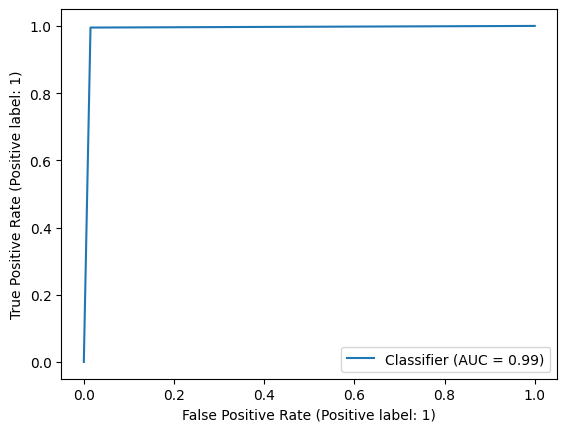

In [20]:
# Plot ROC curve
RocCurveDisplay.from_predictions(y_true=y_val, y_pred=predictions);

#### Confusion Matrix


In [30]:
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize = (10, 10), text_size=20):

  # Create the confusion matrix
  cm =  confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize our confusion matrix
  n_classes = cm.shape[0]

  # Let's prettify it
  fig, ax = plt.subplots(figsize=figsize)
  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

   # Set labels to be classes
  if classes is not None and len(classes) > 0:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title='Confusion Matrix',
        xlabel='Predicted Label',
        ylabel='True Label',
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  # Adjust label size
  ax.yaxis.label.set_size(20)
  ax.xaxis.label.set_size(20)
  ax.title.set_size(20)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f'{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)',
            horizontalalignment='center',
            color='white' if cm[i, j] > threshold else 'black',
            size=text_size)

In [32]:
classes_list = ['AI Generated', 'Human']

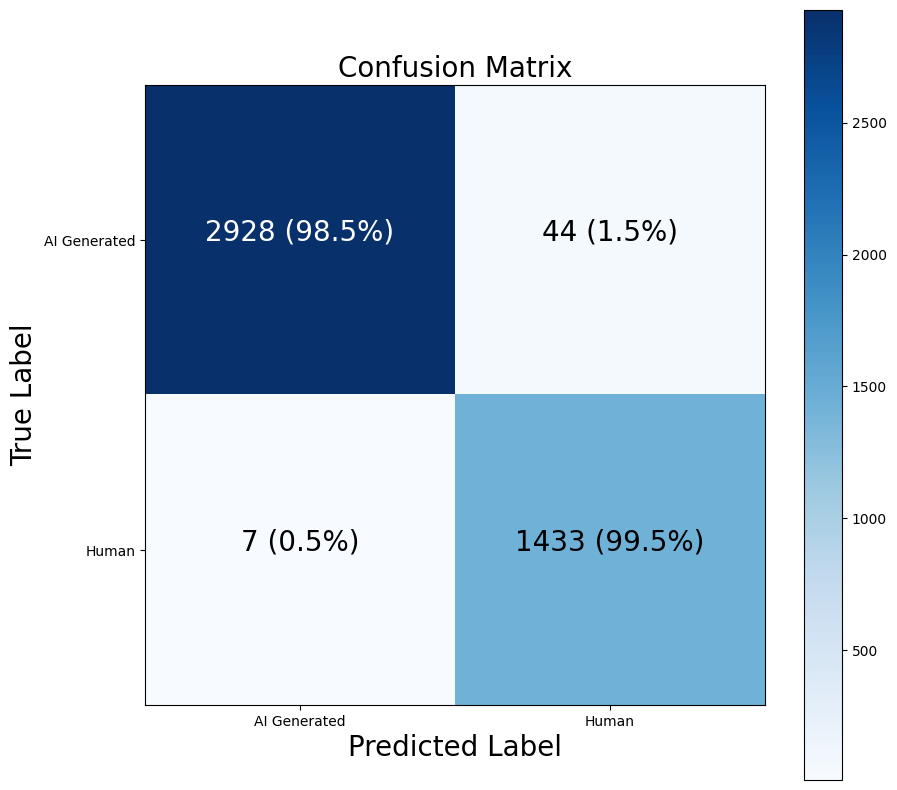

In [37]:
make_confusion_matrix(y_true=y_val, y_pred=predictions, classes=classes_list)

As a we can see the model has a good perfoming analyzing if a text is or not AI Generated. 